In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

# Dog Breeds Classification w/CNN _ VGG16

## 0. 환경 구성

In [1]:
import numpy as np
import pandas as pd
import glob
import cv2
import os
import re
import tensorflow as tf
import matplotlib.pyplot as plt
from PIL import Image
import xml.etree.ElementTree as ET

In [2]:
import torch # 파이토치 기본 라이브러리

# torchvision : 데이터셋, 모델 아키텍처, 컴퓨터 비전의 이미지 변환 기능 제공
from torchvision import datasets 
# torchvision에서 제공하는 데이터셋
from torchvision import transforms 
# 이미지 변환기능을 제공하는 패키지

# torch.utils.data : 파이토치 데이터 로딩 유틸리티
from torch.utils.data import DataLoader 
# 모델 훈련에 사용할 수 있는 미니 배치 구성하고
# 매 epoch마다 데이터를 샘플링, 병렬처리 등의 일을 해주는 함수
from torch.utils.data import Dataset
from torch.utils.data import random_split

from torch.utils.tensorboard import SummaryWriter
from copy import deepcopy

In [3]:
import albumentations as A
from albumentations.pytorch import ToTensorV2

from sklearn.model_selection import train_test_split
from torch.utils.data import Subset

import sys

In [4]:
!nvidia-smi

Mon Apr 17 05:07:43 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.161.03   Driver Version: 470.161.03   CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   38C    P0    26W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [5]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

## 1. 데이터 불러오기

In [ ]:
#from torch.utils.data import Dataset

In [6]:
root_dir = '/kaggle/input/stanford-dogs-dataset'
img_dir = '/images/Images/'
annot_dir = '/annotations/Annotation/'

In [7]:
#import os
labels_map = {}
for i, item in enumerate(os.listdir(root_dir + img_dir)):
    sub_folder = os.path.join(root_dir + img_dir, item)
    labels_map[sub_folder.split('-', maxsplit=3)[-1]] = i

In [ ]:
labels_map

In [ ]:
#import albumentations as A
#from albumentations.pytorch import ToTensorV2

In [ ]:
image = cv2.imread('/kaggle/input/stanford-dogs-dataset/images/Images/n02087046-toy_terrier/n02087046_1004.jpg')
orig_image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

In [ ]:
augmentor = A.RandomBrightnessContrast(brightness_limit=0.2, # -0.2~0.2 범위에서 임의로 밝기 조절. -1:검은색, 1:흰색
                                       contrast_limit=0.2, # brightness_limit와 작동방식 동일
                                       p=0.3 ) # 적용확률. 0.3이면 30%의 확률로 변환기에 적용

augmented_image = augmentor(image=orig_image)['image']
plt.imshow(augmented_image)

In [ ]:
def repeat_aug(count=4, orig_image=None, label=None, augmentor=None):
    image_list = [orig_image]
    label_list = ['Original']

    for i in range(count):
        augmented_image = augmentor(image=orig_image)["image"]
        image_list.append(augmented_image)
        label_list.append(label)

    figure, axes = plt.subplots(nrows=1, ncols=count+1, figsize=(22, 4))
    for i in range(count+1):
        axes[i].imshow(image_list[i])
        axes[i].set_title(label_list[i])

augmentor = A.RandomBrightnessContrast(brightness_limit=0.2, # -0.2~0.2 범위에서 임의로 밝기 조절. -1:검은색, 1:흰색
                                       contrast_limit=0.2, # brightness_limit와 작동방식 동일
                                       p=0.3 ) # 적용확률. 0.3이면 30%의 확률로 변환기에 적용
repeat_aug(count=4, orig_image=orig_image, label='RandomBrightnessContrast', augmentor=augmentor)

In [ ]:
transform = A.Compose([A.Resize(224, 224), A.Normalize(), ToTensorV2()])

In [8]:
def img_crop(annot_path, img):
    tree = ET.parse(annot_path)
    obj = tree.find('./object')
    bndbox = obj.find('bndbox')

    # 강아지 종류
    species = obj.find('name').text

    # 이미지에서의 강아지 위치
    xmin = int(bndbox.find('xmin').text)
    ymin = int(bndbox.find('ymin').text)
    xmax = int(bndbox.find('xmax').text)
    ymax = int(bndbox.find('ymax').text)

    cropped_img = img[ymin:ymax, xmin:xmax]
    
    label = labels_map.get(species)

    return label, cropped_img

#변환기
transform = A.Compose([A.Resize(224, 224), A.Normalize(), ToTensorV2()])

In [9]:
class DogsDataset(Dataset):
    def __init__(self, img_dir, transform=None):
        self.img_dir = glob.glob(root_dir + img_dir + '*/*.jpg')
        self.transform = transform
        
    def __len__(self):
        return len(self.img_dir)
        
    def __getitem__(self, idx):
        img_path = self.img_dir[idx]
        annot_path = img_path.replace('images', 'annotations').replace('Images', 'Annotation').replace('.jpg', '')
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        label, img = img_crop(annot_path, img)
        
        if self.transform is not None:
            img = self.transform(image=img)
            img['label'] = label
            return img
        
        sample = {'image': img, 'label': label}
        return sample

In [10]:
#annotation과 image file들을 imageset으로 받음[전체데이터]
imageset = DogsDataset(img_dir, transform = transform)

In [11]:
imageset[1]

{'image': tensor([[[-1.6042, -1.5357, -1.1932,  ..., -1.4672, -1.4672, -1.5357],
          [-1.6042, -1.4672, -1.0562,  ..., -1.4329, -1.4329, -1.5185],
          [-1.5699, -1.4500, -0.9534,  ..., -1.4158, -1.4672, -1.5357],
          ...,
          [-0.1657, -0.0801, -0.1828,  ...,  0.2282,  0.1768,  0.0912],
          [ 0.2624,  0.1254, -0.2171,  ...,  0.2796,  0.2111,  0.3994],
          [ 0.0741,  0.1254, -0.2171,  ...,  0.3652,  0.1939,  0.5536]],
 
         [[-1.7031, -1.7556, -1.5980,  ..., -1.6856, -1.7556, -1.7731],
          [-1.7556, -1.7556, -1.5805,  ..., -1.6506, -1.7031, -1.7381],
          [-1.7556, -1.7031, -1.4755,  ..., -1.6331, -1.7206, -1.7381],
          ...,
          [-0.1450,  0.0301, -0.0574,  ...,  0.2752,  0.2227,  0.1176],
          [ 0.3277,  0.2052, -0.1275,  ...,  0.3452,  0.2927,  0.4328],
          [ 0.2052,  0.2577, -0.1625,  ...,  0.3803,  0.2227,  0.6078]],
 
         [[-1.5081, -1.6650, -1.4907,  ..., -1.4210, -1.4733, -1.5779],
          [-1.5430,

### 데이터셋 분리

In [ ]:
#from sklearn.model_selection import train_test_split
#from torch.utils.data import Subset

In [13]:
total_label = [data["label"] for data in imageset]

trainset_idx, testset_idx = train_test_split(range(len(imageset)),
                test_size=0.2, random_state=42, 
                shuffle=True, stratify=total_label)

train_set = Subset(imageset, trainset_idx)
#test_set = Subset(imageset, testset_idx)

train_label = [data["label"] for data in train_set]

trainset_idx, validset_idx = train_test_split(range(len(trainset_idx)),
                test_size=0.2, random_state=42, 
                shuffle=True, stratify=train_label)

#train__set = Subset(train_set, trainset_idx)
#valid_set = Subset(train_set, validset_idx)

In [14]:
#train_set = Subset(imageset, trainset_idx)
test_set = Subset(imageset, testset_idx)

train__set = Subset(train_set, trainset_idx)
valid_set = Subset(train_set, validset_idx)

In [ ]:
train_set = Subset(imageset, trainset_idx)
test_set = Subset(imageset, testset_idx)

train__set = Subset(train_set, trainset_idx)
valid_set = Subset(train_set, validset_idx)

In [15]:
imageset[12]

{'image': tensor([[[2.2489, 2.2489, 2.2489,  ..., 2.2489, 2.2489, 2.2489],
          [2.2489, 2.2489, 2.2489,  ..., 2.2489, 2.2489, 2.2489],
          [2.2489, 2.2489, 2.2489,  ..., 2.2489, 2.2489, 2.2489],
          ...,
          [2.2489, 2.2489, 2.2489,  ..., 2.2318, 2.2318, 2.1633],
          [2.2489, 2.2489, 2.2489,  ..., 2.1804, 2.1975, 2.2318],
          [2.2489, 2.2489, 2.2489,  ..., 2.1975, 2.2318, 2.1975]],
 
         [[2.4286, 2.4286, 2.4286,  ..., 2.4286, 2.4286, 2.4286],
          [2.4286, 2.4286, 2.4286,  ..., 2.4286, 2.4286, 2.4286],
          [2.4286, 2.4286, 2.4286,  ..., 2.4286, 2.4286, 2.4286],
          ...,
          [2.4286, 2.4286, 2.4286,  ..., 2.4111, 2.4111, 2.3410],
          [2.4286, 2.4286, 2.4286,  ..., 2.3410, 2.3936, 2.4286],
          [2.4286, 2.4286, 2.4286,  ..., 2.3761, 2.4286, 2.4111]],
 
         [[2.6400, 2.6400, 2.6400,  ..., 2.6400, 2.6400, 2.6400],
          [2.6400, 2.6400, 2.6400,  ..., 2.6400, 2.6400, 2.6400],
          [2.6400, 2.6400, 2.64

In [ ]:
# 1) imageset을 trainset과 testset으로 분리
#from sklearn.model_selection import train_test_split

train_indices, test_indices = train_test_split(
                            range(len(imageset)), # X의 index                        
                            test_size= 0.2, random_state=42)

#from torch.utils.data import Subset

trainset = Subset(imageset, train_indices)
testset = Subset(imageset, test_indices)
#print(trainset[0])

#2) trainset을 다시 한 번 train_set과 valid_set으로 분리
train_indices_, valid_indices = train_test_split(
                            range(len(trainset)), # X의 index                        
                            test_size= 0.2, random_state=42)

train_set = Subset(trainset, train_indices_)
valid_set = Subset(trainset, valid_indices)

#print(train_set[0], valid_set[0])

In [16]:
print(type(train__set), len(train__set))
print(type(valid_set), len(valid_set))
print(type(test_set), len(test_set))

<class 'torch.utils.data.dataset.Subset'> 13171
<class 'torch.utils.data.dataset.Subset'> 3293
<class 'torch.utils.data.dataset.Subset'> 4116


## 2. 시각화1

In [ ]:
def get_image(annot):
    img_path = '/kaggle/input/stanford-dogs-dataset/images/Images/'
    file = annot.split('/')
    img_filename = img_path + file[-2]+'/'+file[-1]+'.jpg'
    return img_filename

In [ ]:
labels_map_lst = list(labels_map.items())
for labels in labels_map_lst:
    lbname = labels[0]
    lbnum = labels[1]

In [17]:
#import re
def get_image_name(annot):
    img_path = '/kaggle/input/stanford-dogs-dataset/images/Images/'
    file_img = annot.split('/')
    img_filename = img_path + file_img[-2]+'/'+file_img[-1]+'.jpg'
    
    split_annot = re.split(r'/|-|_', annot)
    
    breed_name = split_annot[-4]+split_annot[-3]
    #print(file_img, breed_name)
    return img_filename, breed_name

In [ ]:
def get_breed_name(annots):
    labels_map_lst = list(labels_map.items())
    for labels in labels_map_lst:
        lbname = labels[0]
        lbnum = labels[1]
        
    if lbname in annots:
        return lbname
    else:
        pass
    return lbname

In [ ]:
annotations = glob.glob('/kaggle/input/stanford-dogs-dataset/annotations/Annotation/*/*')

get_breed_name(annotations)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:10: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  # Remove the CWD from sys.path while we load stuff.


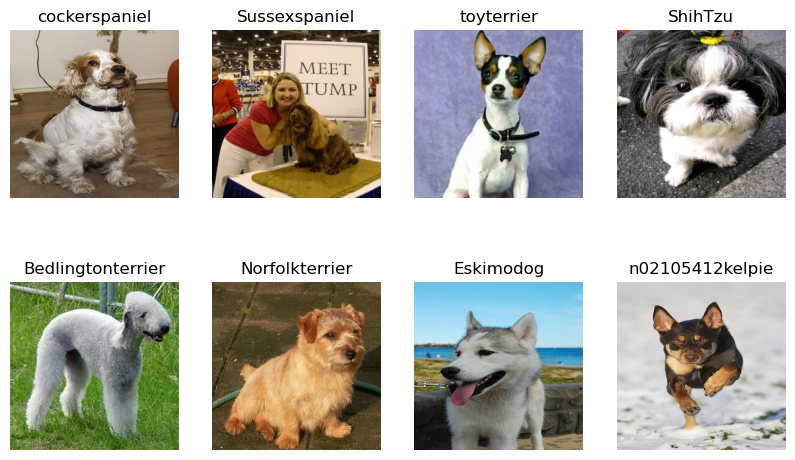

In [19]:
annotations = glob.glob('/kaggle/input/stanford-dogs-dataset/annotations/Annotation/*/*')

figure, axes = plt.subplots(nrows=2, ncols=4, figsize=(10, 6))
axes = axes.flatten()

for i in range(8):
    rand_i = np.random.randint(0, len(train_set))
    dog = get_image_name(annotations[rand_i])
    image = Image.open(dog[0])
    image = image.resize((256,256), Image.ANTIALIAS)
    breeds = dog[1]
    axes[i].axis("off")
    axes[i].imshow(image)
    axes[i].set_title('{}'.format(breeds))

In [20]:
labels_map_lst = list(labels_map.items())
#print(labels_map_lst)
for labels in labels_map_lst:
    print(labels[0])

otterhound
cocker_spaniel
Brittany_spaniel
Afghan_hound
Maltese_dog
schipperke
Irish_setter
Pekinese
golden_retriever
vizsla
Welsh_springer_spaniel
Staffordshire_bullterrier
Border_collie
Irish_terrier
Eskimo_dog
pug
kelpie
Yorkshire_terrier
Tibetan_terrier
Walker_hound
affenpinscher
Cardigan
English_springer
English_foxhound
West_Highland_white_terrier
Lakeland_terrier
Rhodesian_ridgeback
Gordon_setter
Lhasa
curly-coated_retriever
beagle
Tibetan_mastiff
Sussex_spaniel
Saint_Bernard
toy_terrier
standard_poodle
Bernese_mountain_dog
Pomeranian
Ibizan_hound
redbone
toy_poodle
basset
Scottish_deerhound
miniature_pinscher
basenji
Border_terrier
Bedlington_terrier
Kerry_blue_terrier
Weimaraner
English_setter
bluetick
Boston_bull
Italian_greyhound
Dandie_Dinmont
Airedale
Irish_water_spaniel
Norfolk_terrier
wire-haired_fox_terrier
French_bulldog
soft-coated_wheaten_terrier
komondor
African_hunting_dog
Siberian_husky
Newfoundland
Bouvier_des_Flandres
Saluki
Shetland_sheepdog
collie
Rottweiler
s

In [ ]:
#random으로 강아지 사진 가져오기

# annotations = glob.glob('/kaggle/input/stanford-dogs-dataset/annotations/Annotation/*/*')
# labels_map_lst = list(labels_map.items())
# for labels in labels_map_lst:
#     lbname = labels[0]
#     lbnum = labels[1]

# figure, axes = plt.subplots(nrows=2, ncols=4, figsize=(10, 6))
# axes = axes.flatten()

# for i in range(8):
#     rand_i = np.random.randint(0, len(trainset))
#     dog = get_image(annotations[rand_i])
#     image = Image.open(dog)
#     image = image.resize((256,256), Image.ANTIALIAS)
#     breeds = labels_map_lst[rand_i]
#     axes[i].axis("off")
#     axes[i].imshow(image)
#     #axes[i].set_title('Label #{}'.format(breeds[0]))

In [ ]:
#예시 시각화 - annotation 활용해 인식할 강아지 사진  crop해오기'
#함수화

#import xml.etree.ElementTree as ET
#import cv2
#import matplotlib.pyplot as plt

tree = ET.parse('/kaggle/input/stanford-dogs-dataset/annotations/Annotation/n02085620-Chihuahua/n02085620_10074')
obj = tree.find('./object')
bndbox = obj.find('bndbox')

xmin = int(bndbox.find('xmin').text)
ymin = int(bndbox.find('ymin').text)
xmax = int(bndbox.find('xmax').text)
ymax = int(bndbox.find('ymax').text)

src = cv2.imread('/kaggle/input/stanford-dogs-dataset/images/Images/n02085620-Chihuahua/n02085620_10074.jpg')
src = cv2.cvtColor(src, cv2.COLOR_BGR2RGB)

plt.imshow(src[ymin:ymax, xmin:xmax])

## 3. 데이터 적재

**DataLoader, Batch Size**

In [21]:
batch_size = 16 # 100 -> 16
# dataloader = DataLoader(데이터셋, 배치사이즈, 셔플여부.....)
trainloader = DataLoader(train__set, batch_size=batch_size, shuffle=True) 
validloader = DataLoader(valid_set, batch_size=batch_size, shuffle=False) 
testloader = DataLoader(test_set, batch_size=batch_size, shuffle=False) 

In [22]:
13171/16, 3293/16, 4116/16

(823.1875, 205.8125, 257.25)

In [23]:
print(type(trainloader), len(trainloader))
print(type(validloader), len(validloader))
print(type(testloader), len(testloader))

<class 'torch.utils.data.dataloader.DataLoader'> 824
<class 'torch.utils.data.dataloader.DataLoader'> 206
<class 'torch.utils.data.dataloader.DataLoader'> 258


In [24]:
train_iter = iter(trainloader)
batch = next(train_iter)
batch['image'].size(), batch['label'].shape

(torch.Size([16, 3, 224, 224]), torch.Size([16]))

## 4. 모델 생성

In [25]:
import torch.nn as nn # 파이토치 제공 다양한 계층 (Linear Layer, ....)
import torch.optim as optim # 옵티마이저
import torch.nn.functional as F # 파이토치 제공 함수

**VGG16 // conv block 별 사이즈 확인**
- [16, 64, 112, 112]
- [16, 128, 56, 56]
- [16, 512, 28, 28]
- [16, 512, 14, 14]
- [16, 512, 7, 7]

In [ ]:
conv_block1 = nn.Sequential(
                            nn.Conv2d(in_channels=3, out_channels=64, kernel_size=3, stride=1, padding=1),
                            nn.BatchNorm2d(num_features=64),
                            nn.ReLU(),
                            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=1, padding=1),
                            nn.BatchNorm2d(num_features=64),
                            nn.ReLU(),                            
                            nn.MaxPool2d(kernel_size=2, stride=2)
                            ) # [16, 64, 112, 112]
conv_block1_out = conv_block1(batch['image'])                                     
conv_block1_out.shape

In [ ]:
conv_block2 = nn.Sequential(
                            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=1),
                            nn.BatchNorm2d(num_features=128),                                      
                            nn.ReLU(),
                            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, stride=1, padding=1),
                            nn.BatchNorm2d(num_features=128),                                      
                            nn.ReLU(),                            
                            nn.MaxPool2d(kernel_size=2, stride=2)
                            ) # [16, 128, 56, 56]
conv_block2_out = conv_block2(conv_block1_out)                                     
conv_block2_out.shape   

In [ ]:
conv_block3 = nn.Sequential(
                            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, stride=1, padding=1),
                            nn.BatchNorm2d(num_features=256),                                      
                            nn.ReLU(),     
                            nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, stride=1, padding=1),
                            nn.BatchNorm2d(num_features=256),                                      
                            nn.ReLU(),     
                            nn.Conv2d(in_channels=256, out_channels=512, kernel_size=3, stride=1, padding=1),
                            nn.BatchNorm2d(num_features=512),                                      
                            nn.ReLU(),     
                            nn.MaxPool2d(kernel_size=2, stride=2)                                                                                         
                            ) # [16, 512, 28, 28] 
conv_block3_out = conv_block3(conv_block2_out)                                     
conv_block3_out.shape

In [ ]:
conv_block4 = nn.Sequential(
                            nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, stride=1, padding=1),
                            nn.BatchNorm2d(num_features=512),                                      
                            nn.ReLU(),   
                            nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, stride=1, padding=1),
                            nn.BatchNorm2d(num_features=512),                                      
                            nn.ReLU(),  
                            nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, stride=1, padding=1),
                            nn.BatchNorm2d(num_features=512),                                      
                            nn.ReLU(),   
                            nn.MaxPool2d(kernel_size=2, stride=2)                                                                                           
                            ) # [16, 512, 14, 14]
conv_block4_out = conv_block4(conv_block3_out)                                     
conv_block4_out.shape

In [ ]:
conv_block5 = nn.Sequential(
                            nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, stride=1, padding=1),
                            nn.BatchNorm2d(num_features=512),                                      
                            nn.ReLU(),   
                            nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, stride=1, padding=1),
                            nn.BatchNorm2d(num_features=512),                                      
                            nn.ReLU(),   
                            nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, stride=1, padding=1),
                            nn.BatchNorm2d(num_features=512),                                      
                            nn.ReLU(),                                                           
                            nn.MaxPool2d(kernel_size=2, stride=2)                                   
                            ) # [16, 512, 7, 7]
conv_block5_out = conv_block5(conv_block4_out)                                     
conv_block5_out.shape

In [ ]:
avg_pool = nn.AdaptiveAvgPool2d((1, 1)) 
avg_pool_out = avg_pool(conv_block5_out)
avg_pool_out.shape

**VGG16 Model**

In [26]:
class VGG16(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv_block1 = nn.Sequential(
                                    nn.Conv2d(in_channels=3, out_channels=64, 
                                              kernel_size=3, stride=1, padding=1),
                                    nn.BatchNorm2d(num_features=64),
                                    nn.ReLU(),
                                    nn.Conv2d(in_channels=64, out_channels=64, 
                                              kernel_size=3, stride=1, padding=1),
                                    nn.BatchNorm2d(num_features=64),
                                    nn.ReLU(),                            
                                    nn.MaxPool2d(kernel_size=2, stride=2)
                                    ) # [16, 64, 112, 112]
        self.conv_block2 = nn.Sequential(
                                    nn.Conv2d(in_channels=64, out_channels=128, 
                                              kernel_size=3, stride=1, padding=1),
                                    nn.BatchNorm2d(num_features=128),                                      
                                    nn.ReLU(),
                                    nn.Conv2d(in_channels=128, out_channels=128, 
                                              kernel_size=3, stride=1, padding=1),
                                    nn.BatchNorm2d(num_features=128),                                      
                                    nn.ReLU(),                            
                                    nn.MaxPool2d(kernel_size=2, stride=2)
                                    ) # [16, 128, 56, 56]

        self.conv_block3 = nn.Sequential(
                                    nn.Conv2d(in_channels=128, out_channels=256, 
                                              kernel_size=3, stride=1, padding=1),
                                    nn.BatchNorm2d(num_features=256),                                      
                                    nn.ReLU(),     
                                    nn.Conv2d(in_channels=256, out_channels=256, 
                                              kernel_size=3, stride=1, padding=1),
                                    nn.BatchNorm2d(num_features=256),                                      
                                    nn.ReLU(),     
                                    nn.Conv2d(in_channels=256, out_channels=512, 
                                              kernel_size=3, stride=1, padding=1),
                                    nn.BatchNorm2d(num_features=512),                                      
                                    nn.ReLU(),     
                                    nn.MaxPool2d(kernel_size=2, stride=2)                                                                                         
                                    ) # [16, 512, 28, 28]   

        self.conv_block4 = nn.Sequential(
                                    nn.Conv2d(in_channels=512, out_channels=512, 
                                              kernel_size=3, stride=1, padding=1),
                                    nn.BatchNorm2d(num_features=512),                                      
                                    nn.ReLU(),   
                                    nn.Conv2d(in_channels=512, out_channels=512, 
                                              kernel_size=3, stride=1, padding=1),
                                    nn.BatchNorm2d(num_features=512),                                      
                                    nn.ReLU(),  
                                    nn.Conv2d(in_channels=512, out_channels=512, 
                                              kernel_size=3, stride=1, padding=1),
                                    nn.BatchNorm2d(num_features=512),                                      
                                    nn.ReLU(),   
                                    nn.MaxPool2d(kernel_size=2, stride=2)                                                                                           
                                    ) # [16, 512, 14, 14] 

        self.conv_block5 = nn.Sequential(
                                    nn.Conv2d(in_channels=512, out_channels=512, 
                                              kernel_size=3, stride=1, padding=1),
                                    nn.BatchNorm2d(num_features=512),                                      
                                    nn.ReLU(),   
                                    nn.Conv2d(in_channels=512, out_channels=512, 
                                              kernel_size=3, stride=1, padding=1),
                                    nn.BatchNorm2d(num_features=512),                                      
                                    nn.ReLU(),   
                                    nn.Conv2d(in_channels=512, out_channels=512, 
                                              kernel_size=3, stride=1, padding=1),
                                    nn.BatchNorm2d(num_features=512),                                      
                                    nn.ReLU(),                                                           
                                    nn.MaxPool2d(kernel_size=2, stride=2)                                   
                                    ) # [16, 512, 7, 7]   

        self.avg_pool = nn.AdaptiveAvgPool2d((1, 1))  # [16, 512, 1, 1]                                                                                                                              

        self.classifier = nn.Sequential(
                                    nn.Linear(in_features=512, out_features=64),
                                    nn.BatchNorm1d(num_features=64),
                                    nn.ReLU(),
                                    nn.Linear(in_features=64, out_features=120)
                                    )

    def forward(self, x):
        x = self.conv_block1(x) # [16, 64, 112, 112]
        x = self.conv_block2(x) # [16, 128, 56, 56]
        x = self.conv_block3(x) # [16, 512, 28, 28] 
        x = self.conv_block4(x) # [16, 512, 14, 14]
        x = self.conv_block5(x) # [16, 512, 7, 7]
        x = self.avg_pool(x) # [16, 512, 1, 1] 
    
        # reshape할 형상 : (batch_size x 512)
        # x = x.view(-1, 512) # option 1 : view
        x = torch.flatten(x, 1) # option 2 : flatten 
        # x = x.reshape(x.shape[0], -1) # option 3 : reshape

        x = self.classifier(x)    
        return x

In [28]:
model = VGG16()
model.to(device)
print(device)
print(model)

cuda
VGG16(
  (conv_block1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block3): Sequential(
 

In [29]:
images = batch['image']
out = model(images.to(device))
out.shape

torch.Size([16, 120])

In [30]:
for name, parameter in model.named_parameters():
    print(name, parameter.size())

conv_block1.0.weight torch.Size([64, 3, 3, 3])
conv_block1.0.bias torch.Size([64])
conv_block1.1.weight torch.Size([64])
conv_block1.1.bias torch.Size([64])
conv_block1.3.weight torch.Size([64, 64, 3, 3])
conv_block1.3.bias torch.Size([64])
conv_block1.4.weight torch.Size([64])
conv_block1.4.bias torch.Size([64])
conv_block2.0.weight torch.Size([128, 64, 3, 3])
conv_block2.0.bias torch.Size([128])
conv_block2.1.weight torch.Size([128])
conv_block2.1.bias torch.Size([128])
conv_block2.3.weight torch.Size([128, 128, 3, 3])
conv_block2.3.bias torch.Size([128])
conv_block2.4.weight torch.Size([128])
conv_block2.4.bias torch.Size([128])
conv_block3.0.weight torch.Size([256, 128, 3, 3])
conv_block3.0.bias torch.Size([256])
conv_block3.1.weight torch.Size([256])
conv_block3.1.bias torch.Size([256])
conv_block3.3.weight torch.Size([256, 256, 3, 3])
conv_block3.3.bias torch.Size([256])
conv_block3.4.weight torch.Size([256])
conv_block3.4.bias torch.Size([256])
conv_block3.6.weight torch.Size([5

## 5. 모델 컴파일(손실함수, 옵티마이저 선택)

In [31]:
learning_rate = 0.0001
# 손실함수
loss_fn = nn.CrossEntropyLoss()

# 옵티마이저(최적화함수, 예:경사하강법)
# optimizer=optim.SGD(model.parameters(),lr=learning_rate)

# 규제의 강도 설정 weight_decay
optimizer = optim.Adam(model.parameters(), 
                       lr=learning_rate)
# optimizer = optim.Adam(model.parameters(),lr=learning_rate,weight_decay=0.001)

# Learning Rate Schedule
# https://pytorch.org/docs/stable/generated/torch.optim.lr_scheduler.ReduceLROnPlateau.html

# 모니터링하고 있는 값(예:valid_loss)의 최소값(min) 또는 최대값(max) 
#patience 기간동안 줄어들지 않을 때(OnPlateau) lr에 factor(0.1)를 곱해주는 전략
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', 
                                                 factor=0.1, patience=4, verbose=True)

In [ ]:
#from torchsummary import summary

## 6. 모델 훈련

In [32]:
#손실함수, 정확도
def validate(model, validloader, loss_fn):
    total = 0
    correct = 0
    valid_loss = 0
    valid_accuracy = 0
    
    #전방향 예측_no need gradient
    with torch.no_grad():
        for batch in validloader:
            images = batch['image']
            labels = batch['label']
            
            #0. sending Data to GPU
            images, labels = images.to(device), labels.to(device)
            
            #1. 입력 데이터 준비
            #not Flatten
            #images.resize_(images.size()[0], 784)
            
            #2. forward prediction
            logit = model(images) #예측 점수
            _, preds = torch.max(logit, 1)
            # preds = logit.max(dim=1)[1]
            correct += int((preds ==labels).sum())
            total += labels.shape[0]
            
            
            loss = loss_fn(logit, labels)
            valid_loss += loss.item()
            #tensor에서 값을 꺼내와 batch loss 평균값을 valid_loss에 누적
            
        valid_accuracy = correct / total
        
    return valid_loss, valid_accuracy

In [34]:
#루프를 통한 학습
#writer = SummaryWriter()

def train_loop(model, trainloader, loss_fn, epochs, optimizer):  
    steps = 0
    steps_per_epoch = len(trainloader) 
    min_loss = 1000000
    max_accuracy = 0
    trigger = 0
    patience = 7 

    for epoch in range(epochs):
        model.train() # 훈련 모드
        train_loss = 0
        for batch in trainloader: 
            # 이터레이터로부터 next()가 호출되며 미니배치를 반환(images, labels)
            steps += 1

            # images, labels: (torch.Size([16, 3, 224, 224]), torch.Size([16]))
            images = batch['image']
            labels = batch['label']

            # 0. Data를 GPU로 보내기
            images, labels = images.to(device), labels.to(device)

            # 1. 입력 데이터 준비
            # not Flatten !!
            # images.resize_(images.shape[0], 784) 

            # 2. 전방향(forward) 예측
            logit = model(images) # 예측 점수
            loss = loss_fn(logit, labels) 
            # 예측 점수와 정답을 CrossEntropyLoss에 넣어 Loss값 반환

            # 3. 역방향(backward) 오차(Gradient) 전파
            optimizer.zero_grad() # Gradient가 누적되지 않게 하기 위해
            loss.backward() # 모델파리미터들의 Gradient 전파

            # 4. 경사 하강법으로 모델 파라미터 업데이트
            optimizer.step() # W <- W -lr*Gradient

            train_loss += loss.item()
            if (steps % steps_per_epoch) == 0 : 
                model.eval() 
                # 평가 모드 : 평가에 사용 X 계층(배치 정규화, 드롭아웃)들 비사용하기위함
                valid_loss, valid_accuracy = validate(model, validloader, loss_fn)

                # tensorboard 시각화를 위한 로그 이벤트 등록
#                 writer.add_scalar('Train Loss', train_loss/len(trainloader), epoch+1)
#                 writer.add_scalar('Valid Loss', valid_loss/len(validloader), epoch+1)
#                 writer.add_scalars('Train Loss and Valid Loss',
#                                   {'Train' : train_loss/len(trainloader),
#                                     'Valid' : valid_loss/len(validloader)}, epoch+1)
#                 writer.add_scalar('Valid Accuracy', valid_accuracy, epoch+1)
                # -------------------------------------------

                print('Epoch : {}/{}.......'.format(epoch+1, epochs),            
                      'Train Loss : {:.3f}'.format(train_loss/len(trainloader)), 
                      'Valid Loss : {:.3f}'.format(valid_loss/len(validloader)), 
                      'Valid Accuracy : {:.3f}'.format(valid_accuracy)            
                      )
        
                # Best model 저장    
                # option 1 : valid_loss 모니터링
                # if valid_loss < min_loss: 
                # 바로 이전 epoch의 loss보다 작으면 저장
                #   min_loss = valid_loss
                #   best_model_state = deepcopy(model.state_dict())          
                #   torch.save(best_model_state, 'best_checkpoint.pth')     
        
                # option 2 : valid_accuracy 모니터링      
                if valid_accuracy > max_accuracy : 
                    # 바로 이전 epoch의 accuracy보다 크면 저장하기
                    max_accuracy = valid_accuracy
                    best_model_state = deepcopy(model.state_dict())          
                    torch.save(best_model_state, 'best_checkpoint.pth')  
                # -------------------------------------------

                # Early Stopping (조기 종료)
                if valid_loss > min_loss: 
                    # valid_loss가 min_loss를 갱신하지 못하면
                    trigger += 1
                    print('trigger : ', trigger)
                    if trigger > patience:
                        print('Early Stopping !!!')
                        print('Training loop is finished !!')
                        writer.flush()   
                        return
                else:
                    trigger = 0
                    min_loss = valid_loss
                    best_model_state = deepcopy(model.state_dict())
                    torch.save(best_model_state, 'best_checkpoint.pth') 
                # -------------------------------------------

                # Learning Rate Scheduler
                scheduler.step(valid_loss)
                # -------------------------------------------
        
    #writer.flush()
    return  

In [ ]:
#학습루프 2 _ 디버깅 시도 1
def train_loop(model, trainloader, loss_fn, epochs, optimizer):  
    steps = 0
    steps_per_epoch = len(trainloader) 
    min_loss = 1000000
    max_accuracy = 0
    trigger = 0
    patience = 7
    
    for epoch in range(epochs):
        model.train()
        train_loss = 0
        
        for batch in trainloader:
            #iterator로부터 next() 호출, 미니배치 반환(images, labels)
            steps += 1
            
            images = batch['image']
            labels = batch['label']
            
            #Data를 GPU로 보내기
            images, labels = images.to(device), labels.to(device)
            
            #1.
            

In [35]:
epochs = 55 
%time train_loop(model, trainloader, loss_fn, epochs, optimizer)
#writer.close()   

Epoch : 1/55....... Train Loss : 4.678 Valid Loss : 4.582 Valid Accuracy : 0.026
Epoch : 2/55....... Train Loss : 4.476 Valid Loss : 4.387 Valid Accuracy : 0.051
Epoch : 3/55....... Train Loss : 4.307 Valid Loss : 4.252 Valid Accuracy : 0.065
Epoch : 4/55....... Train Loss : 4.145 Valid Loss : 3.995 Valid Accuracy : 0.090
Epoch : 5/55....... Train Loss : 3.988 Valid Loss : 3.973 Valid Accuracy : 0.090
Epoch : 6/55....... Train Loss : 3.871 Valid Loss : 3.792 Valid Accuracy : 0.108
Epoch : 7/55....... Train Loss : 3.727 Valid Loss : 3.611 Valid Accuracy : 0.140
Epoch : 8/55....... Train Loss : 3.569 Valid Loss : 3.572 Valid Accuracy : 0.130
Epoch : 9/55....... Train Loss : 3.421 Valid Loss : 3.426 Valid Accuracy : 0.164
Epoch : 10/55....... Train Loss : 3.274 Valid Loss : 3.233 Valid Accuracy : 0.183
Epoch : 11/55....... Train Loss : 3.125 Valid Loss : 3.064 Valid Accuracy : 0.224
Epoch : 12/55....... Train Loss : 2.948 Valid Loss : 2.953 Valid Accuracy : 0.272
Epoch : 13/55....... Trai

## 7. 모델 예측

In [36]:
test_iter = iter(testloader)
batch = next(test_iter)
images = batch['image']
labels = batch['label']

images, labels = images.to(device), labels.to(device)
print(images.size(), labels.size())

torch.Size([16, 3, 224, 224]) torch.Size([16])


In [38]:
rnd_idx = 10
model.eval()
with torch.no_grad():
    logit = model(images[rnd_idx].unsqueeze(0)) 
    # model.forward()에서는 배치가 적용된 4차원 입력 기대

pred = logit.max(dim=1)[1]
print(pred == labels[rnd_idx]) # True : 잘 예측

tensor([True], device='cuda:0')


In [39]:
#print("pred:", pred, "labels:", labels[rnd_idx])
#print(labels_map[pred.cpu().item()], labels_map[labels[rnd_idx].cpu().item()])

pred: tensor([44], device='cuda:0') labels: tensor(44, device='cuda:0')


KeyError: 44

## 8. 모델 평가

In [40]:
#모델  평가
def evaluation(model, testloader, loss_fn):
    total = 0   
    correct = 0
    test_loss = 0
    test_accuracy = 0

    # 전방향 예측을 구할 때는 gradient가 필요가 없음음
    with torch.no_grad():
        for batch in testloader: 
            # 이터레이터로부터 next()가 호출되며 미니배치를 반환(images, labels)
            images = batch['image']
            labels = batch['label']

            # 0. Data를 GPU로 보내기
            images, labels = images.to(device), labels.to(device)

            # 1. 입력 데이터 준비
            # not Flatten
            # images.resize_(images.size()[0], 784)
      
            # 2. 전방향(Forward) 예측

            logit = model(images) # 예측 점수
            _, preds = torch.max(logit, 1) 
            # 배치에 대한 최종 예측
            # preds = logit.max(dim=1)[1] 
            correct += int((preds == labels).sum()) 
            # 배치 중 맞은 것의 개수가 correct에 누적
            total += labels.shape[0] 
            # 배치 사이즈만큼씩 total에 누적

            loss = loss_fn(logit, labels)
            test_loss += loss.item() 
            # tensor에서 값을 꺼내와서, 배치의 loss 평균값을 valid_loss에 누적

        test_accuracy = correct / total
   
    print('Test Loss : {:.3f}'.format(test_loss/len(testloader)), 
          'Test Accuracy : {:.3f}'.format(test_accuracy))

model.eval()
evaluation(model, testloader, loss_fn)  

Test Loss : 1.748 Test Accuracy : 0.517


## 9. 모델 저장

In [41]:
model.state_dict().keys()

odict_keys(['conv_block1.0.weight', 'conv_block1.0.bias', 'conv_block1.1.weight', 'conv_block1.1.bias', 'conv_block1.1.running_mean', 'conv_block1.1.running_var', 'conv_block1.1.num_batches_tracked', 'conv_block1.3.weight', 'conv_block1.3.bias', 'conv_block1.4.weight', 'conv_block1.4.bias', 'conv_block1.4.running_mean', 'conv_block1.4.running_var', 'conv_block1.4.num_batches_tracked', 'conv_block2.0.weight', 'conv_block2.0.bias', 'conv_block2.1.weight', 'conv_block2.1.bias', 'conv_block2.1.running_mean', 'conv_block2.1.running_var', 'conv_block2.1.num_batches_tracked', 'conv_block2.3.weight', 'conv_block2.3.bias', 'conv_block2.4.weight', 'conv_block2.4.bias', 'conv_block2.4.running_mean', 'conv_block2.4.running_var', 'conv_block2.4.num_batches_tracked', 'conv_block3.0.weight', 'conv_block3.0.bias', 'conv_block3.1.weight', 'conv_block3.1.bias', 'conv_block3.1.running_mean', 'conv_block3.1.running_var', 'conv_block3.1.num_batches_tracked', 'conv_block3.3.weight', 'conv_block3.3.bias', 'c